In [2]:
using RetinalChaos
using Plots
using Statistics

┌ Info: Precompiling RetinalChaos [3f100aef-eb91-46ae-997e-7902479fb568]
└ @ Base loading.jl:1260


In [4]:
#Used for loading Phys data
using PyCall
pyABF = pyimport("pyabf")

PyObject <module 'pyabf' from 'C:\\Users\\mtarc\\Anaconda3\\envs\\RetinalWaves\\lib\\site-packages\\pyabf\\__init__.py'>

In [5]:
using Plots.Measures
using LaTeXStrings, Colors
font_title = Plots.font("Arial", 24)
font_axis = Plots.font("Arial", 12)
font_legend = Plots.font("Arial", 8)
pyplot(titlefont=font_title, guidefont = font_axis, legendfont = font_legend)

Plots.PyPlotBackend()

## Table of contents:

### [0] Introduction to RetinalChaos.jl

### [1] Methods
#### [1.1] Voltage and Potassium gating components of the model
#### [1.2] Calcium and the Biochemical Reactions of the sAHP
#### [1.3] Acetylcholine Diffusion and Dynamics
#### [1.4] Gaussian White noise and dynamics

### _**[2] Analyzing Data Output of the model**_
#### [2.1] Time Scale Analysis
#### [2.2] **Fitting Experimental Data (Patch)**
#### [2.3] Fitting Experimental Data (Multi-electrode array)
#### [2.4] Fitting Experimental Data (Calcium Imageing) 

### [3] Experiments
#### [3.1] Dual Eye Correlations
#### [3.2] Recapitulations of older papers
#### [3.x] Dynamical Analysis

### Optimizing current Models

- We have so far established a acceptable model to characterize the neuronal firing of starburst amacrine cells, and established a method to quantify the timescales within the cells firing. 
- Our goal is to measure how closely our model and quantification is related to actual data including 

##### We can use data collected from whole cell patch clamp to quantify how closely our data matches 

### [2.2.a] Loading Physiological Data from .abf files
- All physiological traces were obtained in ClampEx
- The first thing we have to do is to load the .abf file.

In [43]:
target_folder = "D:\\2019_Renna Lab\\Data\\Patching\\"
target_file = "D:\\Data\\Patching\\2019_11_03_Patch\\Animal_2\\Cell_3\\19n03042.abf"
#Load experimental data
exp_data = pyABF.ABF(target_file)
println("File successfully loaded")
#Extract the time trace, and the 
t = exp_data.sweepX
dt_exp = t[2]
aq = 1/dt
println("Data from time stamp $(t[1]) s to $(t[end]+dt) s with dt = $dt s")
println("Data was acquired at $aq Hz")
println("$(length(t)) data points")

File successfully loaded
Data from time stamp 0.0 s to 300.99995 s with dt = 1.0 s
Data was acquired at 1.0 Hz
6000000 data points


##### Analyzing the data before loading into Julia. 
- It may be helpful to look over data before loading it into the Julia interface. 
- with 300s at 20kHz you will have 6 million data points. This can cause some overhead memory issues. 
- In this specific recording, we only care about 100s (from 130-230s). 

In [44]:
#In order to account for Junction potentials we can add an offset
v_offset = -25.0
#Extract the 1st sweep 1st channel from the .abf file
exp_data.setSweep(sweepNumber = 0, channel = 0);
#Vm is the raw data
vm = Float64.(exp_data.sweepY);
#We reduce the data to 100k data points between 120-_230s for memory saving and graphing. 
reduced = round.(Int, LinRange(Int(130/dt_exp), Int(230/dt_exp), Int(100e3)));
#For some graphing purposes, we reset the timestamps (keeping t as the original)
t_offset = (t[reduced] .- t[reduced][1]).*1000;
#The new interval should be 1ms or 1kHz
dt_sim = round(t_offset[2]-t_offset[1], digits = 2)
println("Reduced data acquisition $dt_sim")

Reduced data acquisition 1.0


In [45]:
#We have two traces:
#2) Normal for data analysis, but slow graphing with the orginal interval
Vm_trace = vm[Int(130/dt_exp):Int(230/dt_exp)].+v_offset;
#1) Reduced for quicker graphing with an interval of 1ms
Vm_trace_RED = vm[reduced].+v_offset;

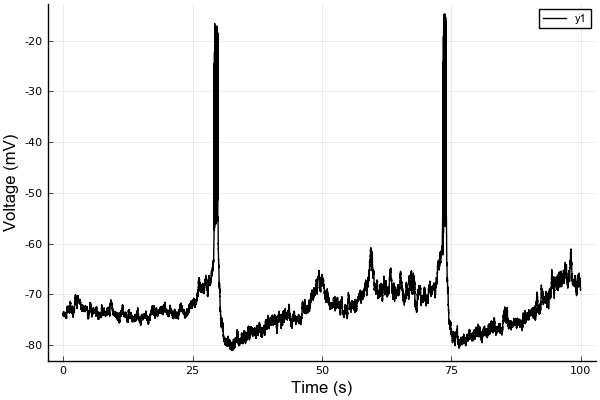

In [46]:
plot(t_offset/1000, Vm_trace_RED, 
    xlabel = "Time (s)", ylabel = "Voltage (mV)", c = :black)

### [2.2.b] Timescale analysis
- As described in the previous notebook, we can extend the quantification methods used to analyze the simulation. 

In [47]:
import RetinalChaos: calculate_threshold, count_intervals, timescale_analysis

In [48]:
threshold = calculate_threshold(Vm_trace);
println("The spiking threshold = $(round(threshold, digits = 2)) mV")
spike_phys = (Vm_trace .> threshold);
intervals = count_intervals(spike_phys)*dt_exp*1000;
println("$(length(intervals)+1) spiking events have been detected")

The spiking threshold = -53.19 mV
119 spiking events have been detected


In [49]:
maximum(intervals)

43496.450000000004

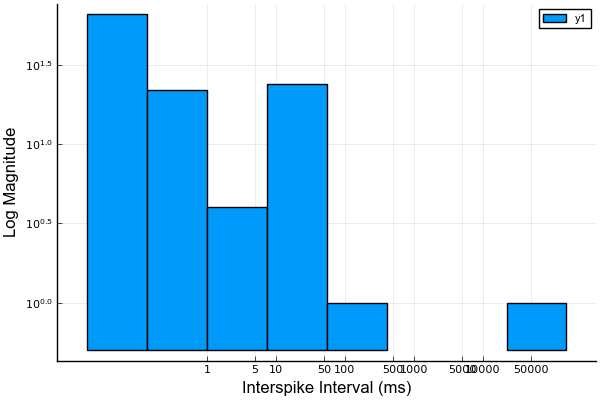

In [50]:
xstops = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000];
xticks = (log.(xstops), xstops);   
histogram(log.(intervals), yaxis = :log, xticks = xticks, ylabel = "Log Magnitude", xlabel = "Interspike Interval (ms)")

In [51]:
#Conducting the analysis in a single function you can use the imported function timescale_analysis
ts_analysis = timescale_analysis(Vm_trace, dt = dt_exp*1000);

### [2.2.c] Visual comparison with simulations. 
- Using the process defined in the previous notebook, we can compare our physiologically obtained data to data that was simulated

In [52]:
import RetinalChaos: read_JSON, extract_dict 
import RetinalChaos: T_sde
import RetinalChaos: SOSRI, SDEProblem, solve

In [53]:
p = read_JSON("params.json") |> extract_dict;
u0 = read_JSON("conds.json") |> extract_dict;
dt = 1.0
tspan = (0.0, 300e3);
SDEprob = SDEProblem(T_sde, u0, tspan, p)
println("Time it took to simulate 200ms:")
@time SDEsol = solve(SDEprob, SOSRI(), abstol = 2e-2, reltol = 2e-2, maxiters = 1e7, saveat = dt); 
trace = Array(SDEsol)';

Time it took to simulate 200ms:
  4.101797 seconds (12.42 M allocations: 567.758 MiB)


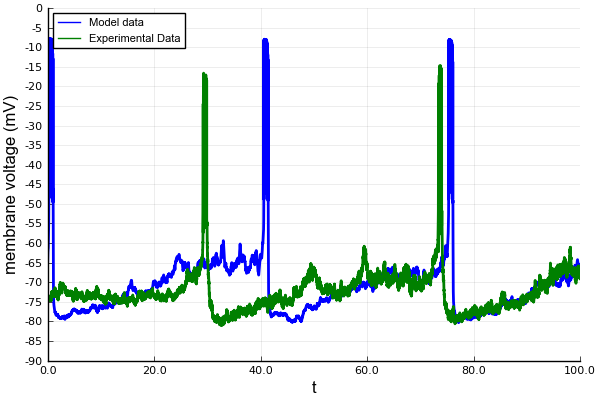

In [54]:
##Here we can plot the traces against each other, they will not always align well.  
xlims = (0, t_offset[end]); ylims = (-90.0, 0.0)
ellapsed_time = (xlims[end]-xlims[1])/1000
dt_lims = 20e3
xticks = (collect(xlims[1]:dt_lims:xlims[2]), collect(0:(dt_lims/1000):ellapsed_time)); yticks = (collect(ylims[1]:5:ylims[2]))

p = plot(xlabel = "time (s)", ylabel = "membrane voltage (mV)")
plot!(p, SDEsol, vars = [:v], label = "Model data", 
    lw = 2.0, c = :blue)
plot!(p, t_offset, Vm_trace_RED, label = "Experimental Data", 
    lw = 2.0, c = :green,
    xlims = xlims, xticks = xticks, 
    ylims = ylims, yticks = yticks
)

In [55]:
#Conducting the analysis in a single function you can use the imported function timescale_analysis
println("Timescale analysis for simulation")
sim_analysis = timescale_analysis(trace[:,1]; dt = dt);
sim_thresh = calculate_threshold(trace[:,1])
println("The spiking threshold = $(round(sim_thresh, digits = 2)) mV")
sim_spike = (trace[:,1] .> sim_thresh);
sim_intervals = count_intervals(sim_spike) .*dt;
println("$((sim_intervals|>length)+1) spiking events have been detected")

Timescale analysis for simulation
The spiking threshold = -37.4 mV
343 spiking events have been detected


In [56]:
println("Timescale analysis for physiological trace")
exp_analysis = timescale_analysis(Vm_trace, dt = dt_exp*1000);
exp_thresh = calculate_threshold(Vm_trace)
println("The spiking threshold = $(round(exp_thresh, digits = 2)) mV")
exp_spike = (Vm_trace .> exp_thresh);
exp_intervals = count_intervals(exp_spike) .*dt_exp*1000;
println("$((exp_intervals|>length)+1) spiking events have been detected")

Timescale analysis for physiological trace
The spiking threshold = -53.19 mV
119 spiking events have been detected


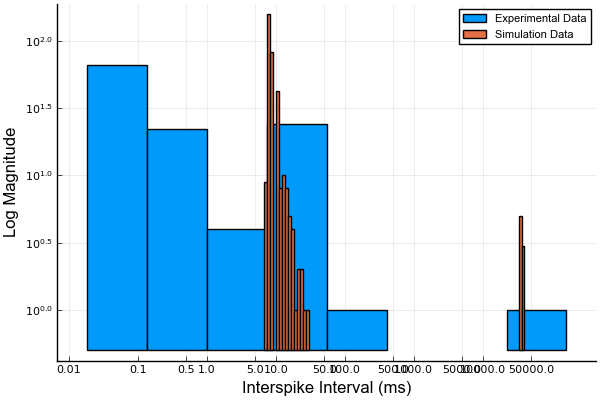

In [57]:
xstops = [0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000];
xticks = (log.(xstops), xstops);  
histogram(log.(exp_intervals), yaxis = :log, label = "Experimental Data")
histogram!(log.(sim_intervals), yaxis = :log, label = "Simulation Data", xticks = xticks, ylabel = "Log Magnitude", xlabel = "Interspike Interval (ms)")

In [58]:
using StatsPlots
import RetinalChaos: interleave

In [59]:
groups = repeat(["Model","Experimental"], outer = 3)
datapoints = interleave(exp_analysis[1:2:end], sim_analysis[1:2:end]);
yerr = interleave(exp_analysis[2:2:end], sim_analysis[2:2:end]);

In [60]:
gb1 = bar(datapoints[1:2], yerr = yerr[1:2], bar_width = 0.75, group = groups[1:2], ylabel = "Spike Dur (ms)", ylims = (0, Inf));
gb2 = bar(datapoints[3:4], yerr = yerr[3:4], bar_width = 0.75, group = groups[3:4], ylabel = "Burst Dur (ms)", legend = false);
gb3 = bar(datapoints[5:6]./1000, yerr = yerr[5:6]./1000, bar_width = 0.75, group = groups[5:6], ylabel = "IBI (s)", legend = false);

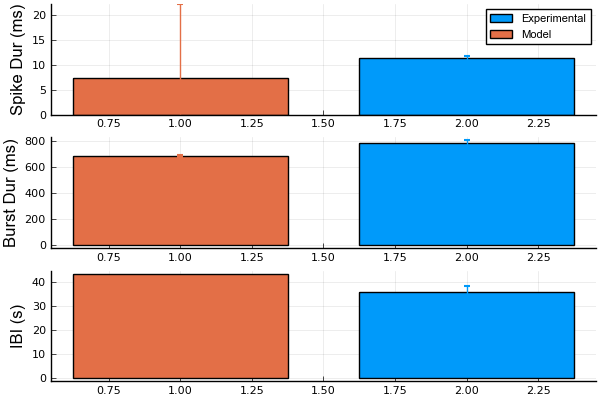

In [61]:
plot(gb1, gb2, gb3, layout = grid(3,1))

### [2.2.d] We can analyze many files in a automated fashion. 
- We need to be able to parse through a file heirarchy and grab not only the patch traces, but regions where the patch traces are decent. 
- Jordan has indicated which recordings are decent. This could help eliminate several traces which are not going to be good. 

In [62]:
import RetinalChaos: parse_abf, extract_abf

In [63]:
function extract_abf(abf_path; verbose = false, v_offset = -25.0)
    if length(abf_path |> splitpath) > 1
        full_path = abf_path
    else
        full_path = joinpath(pwd(), abf_path)   
    end
    #extract the abf file by using pyABF
    exp_data = pyABF.ABF(full_path)
    #if the data is segmented into sweeps (which Jordans data is) concatenate all sweeps
    if length(exp_data.sweepList) > 1
        data = Float64[]
        time = Float64[]
        previous_time = 0.0
        for sweepNumber in exp_data.sweepList
            exp_data.setSweep(sweepNumber = sweepNumber, channel = 0);
            push!(data, exp_data.sweepY...);
            push!(time, (exp_data.sweepX.+previous_time)...);
            previous_time = time[end]
        end
        dt = time[2]*1000
    else
        exp_data.setSweep(sweepNumber = 0, channel = 0);
        data = Float64.(exp_data.sweepY);
        time = Float64.(exp_data.sweepX);
        dt = time[2]*1000
        
    end
    if verbose
        println("Data extracted from $full_path")
        println("Data from time stamp $(t[1]) s to $(t[end]+dt) s with dt = $dt ms")
        println("Data was acquired at $(1/dt/1000) Hz")
        println("$(length(t)) data points")
    end
    data, time, dt
end

extract_abf (generic function with 1 method)

In [64]:
target_folder = "D:\\Data\\Jordans_Patch_Data\\Starburst Recordings\\"
target_file = "D:\\Data\\Patching\\2019_11_03_Patch\\Animal_2\\Cell_3\\19n03042.abf"
@time paths = target_folder |> parse_abf;

  0.060738 seconds (6.62 k allocations: 417.812 KiB)


In [65]:
plot(time[1:1000:end], vm_trace[1:1000:end])

MethodError: MethodError: no method matching lastindex(::typeof(time))
Closest candidates are:
  lastindex(!Matched::Core.SimpleVector) at essentials.jl:602
  lastindex(!Matched::Cmd) at process.jl:639
  lastindex(!Matched::Base64.Buffer) at D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.4\Base64\src\buffer.jl:19
  ...

In [66]:
spike_durs = Float64[]
burst_durs = Float64[]
IBIs = Float64[]
@time for (i, path) in enumerate(paths)
    println(i)
    vm_trace, time, dt_exp = extract_abf(path; verbose = false);
    ts_analysis = timescale_analysis(vm_trace, dt = dt_exp);
    push!(spike_durs, ts_analysis[1])
    push!(burst_durs, ts_analysis[3])
    push!(IBIs, ts_analysis[5])
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
223.541758 seconds (639.06 M allocations: 49.795 GiB, 2.49% gc time)


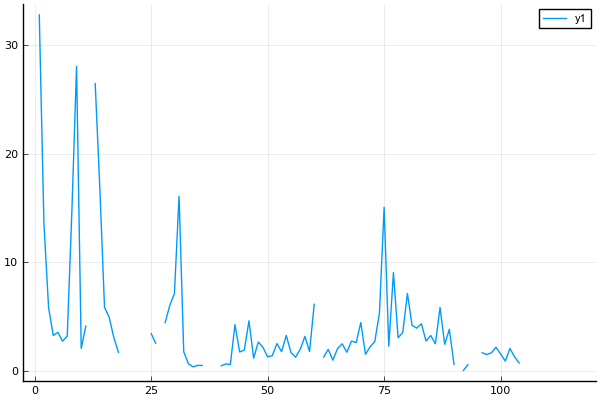

In [67]:
plot(spike_durs)

In [82]:
#Remove any NaN values
spike_durs = spike_durs[spike_durs .|> !isnan];
burst_durs = burst_durs[burst_durs .|> !isnan];
IBIs = IBIs[IBIs .|> !isnan];
println(length(spike_durs))
println(length(burst_durs))
println(length(IBIs))

92
87
83


This is the output from running the entire analysis on the patch files. 

In [69]:
mean_spike_dur = sum(spike_durs)/length(spike_durs)
std_spike_dur = std(spike_durs)
mean_burst_dur = sum(burst_durs)/length(burst_durs)
std_burst_dur = std(burst_durs)
mean_IBI = sum(IBIs./1000)/length(IBIs./1000)
std_IBI = std(IBIs./1000)

36.86655567577998

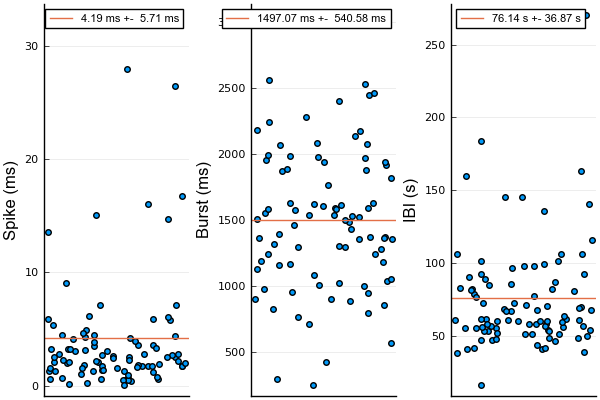

In [70]:
p1 = scatter(rand(length(spike_durs)), spike_durs, ylabel = "Spike (ms)", xaxis = nothing, label = "")
hline!(p1, [mean_spike_dur], label = "$(round(mean_spike_dur, digits = 2)) ms +-  $(round(std_spike_dur, digits = 2)) ms")
#violin!(p1, spike_durs)

p2 = scatter(rand(length(burst_durs)), burst_durs, ylabel = "Burst (ms)", xaxis = nothing, label = "")
hline!(p2, [mean_burst_dur], label = "$(round(mean_burst_dur, digits = 2)) ms +-  $(round(std_burst_dur, digits = 2)) ms")
#violin!(p2, burst_durs)

p3 = scatter(rand(length(spike_durs)), IBIs./1000, ylabel = "IBI (s)", xaxis = nothing, label = "")
hline!(p3, [mean_IBI], label = "$(round(mean_IBI, digits = 2)) s +- $(round(std_IBI, digits = 2)) s")
#violin!(p3, IBIs./1000)

plot(p1, p2, p3, layout = grid(1,3))

[2.2.e] There are about 92 good recordings. In order to make a good comparison with our data, we can run repeated trials on single trace
- We will run the analysis for ~100 trials and compare to our experimental data.
- We can use the ensemble analysis described in the previous notebook

In [71]:
import RetinalChaos: ensemble_func, EnsembleProblem, EnsembleThreads

In [72]:
n_sims = 50
par = :none
p_range = collect(1:n_sims)
prob_func(prob, i, repeat) = ensemble_func(prob, i, repeat; pars = par, rng = p_range)
ensemble_prob = EnsembleProblem(SDEprob, prob_func = prob_func)

EnsembleProblem with problem SDEProblem

In [73]:
@time sim = solve(ensemble_prob, SOSRI(), abstol = 2e-2, reltol = 2e-2, maxiters = 1e7, saveat = dt, trajectories = n_sims, EnsembleThreads(), save_idxs = [1]);

 50.696143 seconds (124.53 M allocations: 6.450 GiB, 56.53% gc time)


In [74]:
sim_spike_durs = Float64[]
sim_burst_durs = Float64[]
sim_IBIs = Float64[]
for (idx, traj) in enumerate(sim)
    val = p_range[idx]
    #println("$idx -> $val")
    trace = Array(traj)'
    mean_spike_dur, std_spike_dur, mean_burst_dur, std_burst_dur, mean_ibi, std_ibi = timescale_analysis(trace[:,1]; dt = dt)
    push!(sim_spike_durs, mean_spike_dur)
    push!(sim_burst_durs, mean_burst_dur)
    push!(sim_IBIs, mean_ibi./1000)
end

In [75]:
sim_mean_spike_dur = sum(sim_spike_durs)/length(sim_spike_durs)
sim_std_spike_dur = std(sim_spike_durs)
sim_mean_burst_dur = sum(sim_burst_durs)/length(sim_burst_durs)
sim_std_burst_dur = std(sim_burst_durs)
sim_mean_IBI = sum(sim_IBIs)/length(sim_IBIs)
sim_std_IBI = std(sim_IBIs)

1.4490330457229508

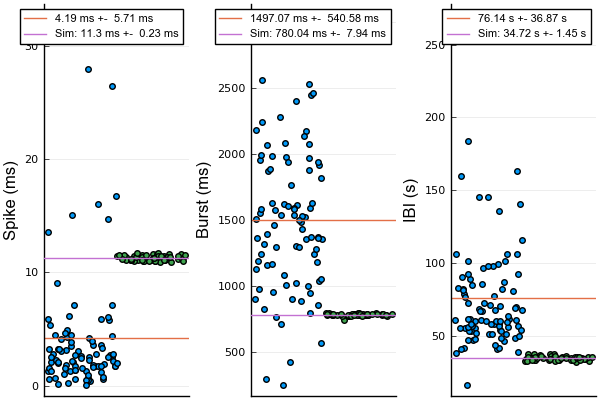

In [76]:
scatter!(p1, rand(length(sim_spike_durs)).+1, sim_spike_durs, ylabel = "Spike (ms)", xaxis = nothing, label = "")
hline!(p1, [sim_mean_spike_dur], label = "Sim: $(round(sim_mean_spike_dur, digits = 2)) ms +-  $(round(sim_std_spike_dur, digits = 2)) ms")
#hspan!(p1, [sim_mean_spike_dur - sim_std_spike_dur, sim_mean_spike_dur + sim_std_spike_dur], alpha = 0.4, c = :blue, label = "")

scatter!(p2, rand(length(sim_burst_durs)).+1, sim_burst_durs, ylabel = "Burst (ms)", xaxis = nothing, label = "")
hline!(p2, [sim_mean_burst_dur], label = "Sim: $(round(sim_mean_burst_dur, digits = 2)) ms +-  $(round(sim_std_burst_dur, digits = 2)) ms")
#violin!(p2, [sim_mean_burst_dur - sim_std_burst_dur, sim_mean_burst_dur + sim_std_burst_dur], alpha = 0.4, c = :blue, label = "")

scatter!(p3, rand(length(sim_IBIs)).+1, sim_IBIs, ylabel = "IBI (s)", xaxis = nothing, label = "")
hline!(p3, [sim_mean_IBI], label = "Sim: $(round(sim_mean_IBI, digits = 2)) s +- $(round(sim_std_IBI, digits = 2)) s")
#hspan!(p3, [sim_mean_IBI - sim_std_IBI, sim_mean_IBI + sim_std_IBI], alpha = 0.4, c = :blue, label = "")

plot(p1, p2, p3, layout = grid(1,3))

### [2.2.f] Actively fitting the Data
- Using a combination of a Ensemble Test and data analysis we can adjust parameters of the model to try to pick the optimal

In [77]:
n_sims = 50
par_sym = :g_Ca
par = findall(isequal(par_sym), Symbol.(RetinalChaos.T_sde.ps))[1]
p_range = LinRange(7.0, 25.0, n_sims)
prob_func(prob, i, repeat) = ensemble_func(prob, i, repeat; pars = par, rng = p_range)
ensemble_prob = EnsembleProblem(SDEprob, prob_func = prob_func)

EnsembleProblem with problem SDEProblem

In [78]:
@time sim = solve(ensemble_prob, SOSRI(), abstol = 2e-2, reltol = 2e-2, maxiters = 1e7, saveat = dt, trajectories = n_sims, EnsembleThreads(), save_idxs = [1]);

 49.543150 seconds (131.58 M allocations: 6.528 GiB, 49.62% gc time)


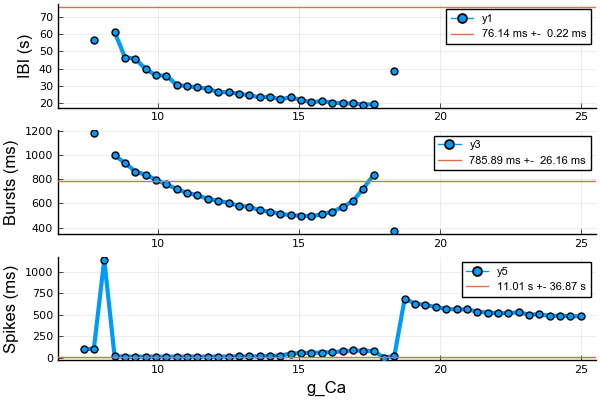

In [79]:
vars = [:v]
vals = []; e_spike_durs = []; e_burst_durs = []; e_ibis = []
for (idx, traj) in enumerate(sim)
    val = p_range[idx]
    #println("$idx -> $val")
    trace = Array(traj)'
    e_mean_spike_dur, e_std_spike_dur, e_mean_burst_dur, e_std_burst_dur, e_mean_ibi, e_std_ibi = timescale_analysis(trace[:,1]; dt = dt)
    push!(vals, val)
    push!(e_spike_durs, e_mean_spike_dur)
    push!(e_burst_durs, e_mean_burst_dur)
    push!(e_ibis, e_mean_ibi./1000)
end
p = plot(layout = grid(3,1))
plot!(p[1], vals, e_ibis, marker = :circle, markersize = 5, lw = 3.0, ylabel = "IBI (s)")
hline!(p[1], [mean_IBI], label = "$(round(mean_IBI, digits = 2)) ms +-  $(round(std_spike_dur, digits = 2)) ms")

plot!(p[2], vals, e_burst_durs, marker = :circle, markersize = 5, lw = 3.0, ylabel = "Bursts (ms)")
hline!(p[2], [mean_burst_dur], label = "$(round(mean_burst_dur, digits = 2)) ms +-  $(round(std_burst_dur, digits = 2)) ms")

plot!(p[3], vals, e_spike_durs, marker = :circle, markersize = 5, lw = 3.0, ylabel = "Spikes (ms)", xlabel = "$par_sym")
hline!(p[3], [mean_spike_dur], label = "$(round(mean_spike_dur, digits = 2)) s +- $(round(std_IBI, digits = 2)) s")
